In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from python_tsp.distances import euclidean_distance_matrix
from python_tsp.heuristics import solve_tsp_local_search

np.set_printoptions(suppress=True)

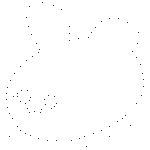

In [2]:
raw_image = Image.open('pixels.png')
raw_image

In [3]:
# Usually, this array transformation is supposed to give us
# a 3D ndarray of RGBA values for each pixel.
# This one, for reasons that are probably "python magic",
# gives us a 2D pseudo-bool ndarray where transparent
# pixels are 1 and non-transparent ones are 0.
all_pixels = np.asarray(raw_image)
all_pixels.shape

(150, 150)

In [4]:
np.unique(all_pixels)

array([0, 1], dtype=uint8)

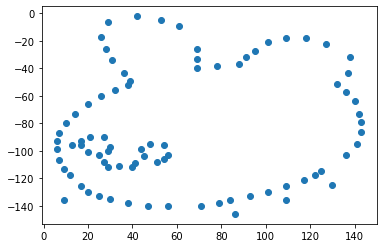

In [5]:
# So we end up needing the indices of the zeroes.
pixels = (all_pixels == 0).nonzero()
# Graphics coördinates start from the top left, and maths
# coördinates from the bottom left, so we need to flip the
# y-axis in the plot.
# The eventual goal is to draw this in CSS which starts from
# top left, so we actually want to keep the values as they are now.
plt.scatter(pixels[1], pixels[0] * -1)

what a cutie :3

In [6]:
# What nonzero() returned was a 2×n array where the first row was the
# row indices/y-coördinates of each point, and the second was the
# column indices/x-coördinates.
# Let's massage this into a n×2 array of each point's coördinates
points = np.transpose([pixels[1], pixels[0]])

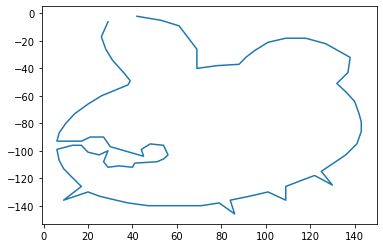

In [9]:
# The points now need to be sorted into a path along the outline.
# There's probably a smarter way to do this, even sorting them manually,
# but it's so much easier to throw them into a Travelling Salesman solver.
distances = euclidean_distance_matrix(points)
permutation, distance = solve_tsp_local_search(distances)
# Let's see how it looks!
plt.plot(points[permutation,0], points[permutation,1] * -1)
# If it looks bad, try refreshing the cell a bunch
# to get a different seed for the heuristic

not *as* cute, but ok!

In [10]:
# Massaging the data some more before running FFT.
sorted_points = points[permutation]
# We have (x, y) coördinate pairs, but want complex
# numbers.
as_complex = sorted_points[:,0] + (1j * sorted_points[:,1])
# For scalability, instead of pixel positions, convert the coördinates
# to percentages of the image size
normalized = as_complex / 150

In [11]:
# Now we can run the FFT
fourier_coeffs = np.fft.fft(normalized, norm='forward')
fourier_coeffs.shape

(83,)

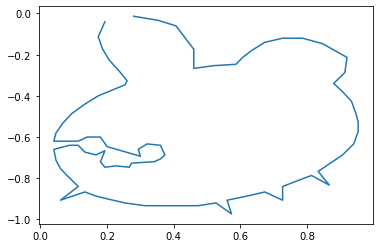

In [12]:
# Reversing the FFT to check the image still looks fine
inverse = np.fft.ifft(fourier_coeffs, norm='forward')
plt.plot(inverse.real, inverse.imag * -1)

In [14]:
# This animation will draw and erase the shape.
# References: 
# https://css-tricks.com/svg-line-animation-works/
# https://css-tricks.com/a-trick-that-makes-drawing-svg-lines-way-easier/
anim_duration = 20
line_anim_css_template = '.traced {{\n\
  animation: trace {svg_anim_duration}s linear forwards infinite;\n\
}}\n\
\n\
@keyframes trace {{\n\
  0% {{\n\
    stroke-dashoffset: 0;\n\
  }}\n\
  100% {{\n\
    stroke-dashoffset: {twice_num_points};\n\
  }}\n\
}}\n'
line_anim_css = line_anim_css_template.format(
    svg_anim_duration = anim_duration * 2,
    twice_num_points = len(points) * 2
)
print(line_anim_css)

.traced {
  animation: trace 40s linear forwards infinite;
}

@keyframes trace {
  0% {
    stroke-dashoffset: 0;
  }
  100% {
    stroke-dashoffset: 166;
  }
}



In [15]:
# Converting the points to a set of SVG lines
# Why not a path? The Fourier transform interprets the points
# as being evenly spaced in time. If we animate the drawing of
# a path, the time taken to draw the line between them is
# proportional to their distance. The workaround is to draw a
# series of lines, and declare their lengths as equal.

# Interpret the percentages as coördinates on a 500px × 500px
# canvas.
# At 100px × 100px, the lines look too thick when the image
# is scaled up.
as_pixels = (normalized * 500)
closed_path = np.append(as_pixels, as_pixels[0])

line_template = '<line class="traced" x1="{x1:.2f}" y1="{y1:.2f}" x2="{x2:.2f}" y2="{y2:.2f}" stroke="black" pathLength="1" \
stroke-dasharray="0 {line_num} {total_lines} {remaining}" />'
# We need a line from the last point back to the first one

lines = [ ]
for i in range(len(closed_path) - 1):
    p1 = closed_path[i]
    p2 = closed_path[i+1]
    line = line_template.format(
        x1 = p2.real,
        y1 = p2.imag,
        x2 = p1.real,
        y2 = p1.imag,
        line_num = i + 1,
        total_lines = len(as_pixels),
        remaining = len(as_pixels) - (i + 1),
        svg_anim_duration = anim_duration * 2,
        twice_num_points = len(as_pixels) * 2
    )
    lines.append(line)

svg_lines = "\n".join(lines) + "\n"

print(svg_lines)

<line class="traced" x1="176.67" y1="16.67" x2="140.00" y2="6.67" stroke="black" pathLength="1" stroke-dasharray="0 1 83 82" />
<line class="traced" x1="203.33" y1="30.00" x2="176.67" y2="16.67" stroke="black" pathLength="1" stroke-dasharray="0 2 83 81" />
<line class="traced" x1="230.00" y1="86.67" x2="203.33" y2="30.00" stroke="black" pathLength="1" stroke-dasharray="0 3 83 80" />
<line class="traced" x1="230.00" y1="110.00" x2="230.00" y2="86.67" stroke="black" pathLength="1" stroke-dasharray="0 4 83 79" />
<line class="traced" x1="230.00" y1="133.33" x2="230.00" y2="110.00" stroke="black" pathLength="1" stroke-dasharray="0 5 83 78" />
<line class="traced" x1="260.00" y1="126.67" x2="230.00" y2="133.33" stroke="black" pathLength="1" stroke-dasharray="0 6 83 77" />
<line class="traced" x1="293.33" y1="123.33" x2="260.00" y2="126.67" stroke="black" pathLength="1" stroke-dasharray="0 7 83 76" />
<line class="traced" x1="303.33" y1="106.67" x2="293.33" y2="123.33" stroke="black" pathLen

In [16]:
# With that tangent out of the way, let's get back to epicycles

In [17]:
# numpy's fft returns the Fourier coëfficients starting with the constant
# term, those for positive frequencies in ascending order, then for negative
# frequencies in descending order, with an equal number of each.
# i.e. 0, 1/n, 2/n, ..., -3/n, -2/n, -1/n
# (if there were an even number of sample points, to keep the
# array length the same, the Nyquist frequency will be between
# them, which we don't need.)
# Let's reärrange them so they're alternating and starting with the
# slowest ones first.
# i.e. 1/n, -1/n, 2/n, -2/n,...
terms_to_take = (fourier_coeffs.size-1)//2
pos = fourier_coeffs[1:terms_to_take+1]
neg = fourier_coeffs[-terms_to_take:]
interleaved = np.empty(2 * terms_to_take, dtype=complex)
interleaved[0::2] = pos
interleaved[1::2] = np.flip(neg)
# This should be the even number just below the number of points
print(interleaved.size)

82


In [18]:
# We'll need the animation durations for later as well.
# We can use the same principle here.
frequencies = np.fft.fftfreq(fourier_coeffs.size, d=anim_duration/fourier_coeffs.size)
freq_interleaved = np.empty(2 * terms_to_take, dtype=float)
pos_freq = frequencies[1:terms_to_take+1]
neg_freq = frequencies[-terms_to_take:]
freq_interleaved[0::2] = pos_freq
freq_interleaved[1::2] = np.flip(neg_freq)

durations = 1 / freq_interleaved

In [19]:
# With the exception of the constant term,
# the coëfficients are most useful to us in polar form,
# so that we can scale and rotate the circles
radii = np.abs(interleaved)
angles = np.angle(interleaved, deg=True)

In [20]:
# Here's where things get really fun:
# The units of the radii are percentages
# of the whole drawing, but percent sizes
# for nested divs are relative to the containing one.
# To get the percentages we need, we have to solve
# outer_percent * div_percent = percent_of_whole
# for div_percent, where percent_of_whole are the ones
# from the Fourier coëfficients.
# Fortunately we don't need to do a whole bunch of multiplications
# to figure out what the real size of the outer div is, that'll just be
# the previous coëfficient's radius.
outer_pcts = np.concatenate(([0.5], radii[:-1]))
# Additionally HTML widths and heights correspond to the
# diameter, not the radius.
div_pcts = (radii / outer_pcts) * 100

In [21]:
# Angles have a similar issue. If the parent div is rotated,
# a rotation on the inner one will be added onto that.
# We can use the same idea as with the radii, just noting
# that angles are added and not multiplied.
outer_angles = np.concatenate(([0], angles[:-1]))
div_angles = angles - outer_angles
# To make the next math easier, the angles should be non-negative.
for i in range(len(div_angles)):
    while div_angles[i] < 0:
        div_angles[i] += 360

In [22]:
# But here's where angles get really fun: the spin animation is defined as transitioning
# an element's transform from a 0° rotation at the start to a 360°
# rotation at the end. We can't just slap a transform on the divs,
# because the animation just overrides it.
# What we'll have to do is add an offset to the animation timing,
# so that at the global t=0 the animation will already be at the point
# where the div is at its required starting angle.
# But also! the negative frequency epicycles play the animation in reverse,
# so the offset needs to be mirrored.
# To avoid a delay before the animation starts, the offset should be negative.

# What we can do is start by calculating the point at which the animation
# reaches the desired angle. Then for the positive frequencies, negate it,
# and for negative frequencies, subtract one period.

# For an animation duration D, we go from 0° at t=0 to
# 360° at t=D. So we achieve angle α at t= D * α / 360

base_timings = np.multiply(durations, div_angles) / 360
anim_delays = np.empty(len(div_angles), dtype=float)
anim_delays[0::2] = base_timings[0::2] * -1
anim_delays[1::2] = (base_timings[1::2] * -1) + durations[1::2]

In [23]:
# Shared styling for the epicycles
epicycle_css = \
'@keyframes spin {\
    to {\
        transform: rotate(360deg);\
    }\
}\
\
.container {\
    position: absolute;\
    box-sizing: border-box;\
    display: flex;\
    align-items: center;\
}\
\
.circle {\
    width: 100%;\
    height: 100%;\
    border-radius: 50%;\
    border: 1px dashed black;\
}\
\
.line {\
    position:absolute;\
    border-bottom: 1px solid black;\
    width: 50%;\
    height: 0%;\
    left :50%;\
}\
\
.tracer {\
    position: absolute;\
    right: -5px;\
    height: 10px;\
    width: 10px;\
    border: 0px solid blue;\
    border-radius: 50%;\
    background: blue;\
}\n'

In [24]:
# Plug the radii and angles into the styles of a div
first_cycle_template = \
'<div class="container" \
style="\
width: {size}%;\
height: {size}%;\
left: {left_offset}%;\
top: {top_offset}%;\
">\
\
<div class="circle"></div>\
<div class="container" \
style="\
width: 100%;\
height: 100%;\
animation: spin {period}s linear infinite{direction};\
animation-delay: {anim_delay}s;\">\
<div class="line"></div>\
'

# As the parent div rotates, the angle of its
# children changes with it. For the inner circles
# to rotate at the right frequency, their parent's
# spin needs to be cancelled out first.
# (The child *could* spin faster, but the number
# of cycles each one would have to complete follows this
# sequence: https://oeis.org/A000975
# and, lol, lmao. there are 82 circles here.)
div_position_template = \
'<div class="container" \
style="\
width: {size}%;\
height: {size}%;\
right: -{half_size}%;\
animation: spin {parent_period}s linear infinite{direction};\">\
<div class="circle"></div>\
<div class="container" \
style="\
width: 100%;\
height: 100%;\
animation: spin {period}s linear infinite{direction};\
animation-delay: {anim_delay}s;">\
<div class="line"></div>\
'
# Leaving the outer divs unclosed. We'll do the nesting by concatenating the filled-in templates
# then closing all the divs.

In [25]:
divs = [''] * (len(interleaved) + 1)
first = first_cycle_template.format(
    size = div_pcts[0],
    left_offset = (fourier_coeffs[0].real - radii[0]) * 100,
    top_offset = (fourier_coeffs[0].imag - radii[0]) * 100,
    period = abs(durations[0]),
    direction = '',
    anim_delay = anim_delays[0]
)
divs[0] = first

In [26]:
for i in range(1, len(interleaved)):
    direction = '' if durations[i] > 0 else ' reverse'
    curr = div_position_template.format(
        size = div_pcts[i],
        half_size = div_pcts[i] / 2,
        parent_period = abs(durations[i-1]),
        period = abs(durations[i]),
        direction = direction,
        anim_delay = anim_delays[i]
    )
    divs[i] = curr
# Add a tracer dot
divs[-1] = '<div class="tracer"></div>'

In [27]:
full_divs = ''.join(divs) + ('</div>' * (2 * len(interleaved)))

In [28]:
print(full_divs)

<div class="container" style="width: 69.63574937364514%;height: 69.63574937364514%;left: 6.338751819201543%;top: 21.093771899522817%;"><div class="circle"></div><div class="container" style="width: 100%;height: 100%;animation: spin 20.0s linear infinite;animation-delay: -15.069904463644546s;"><div class="line"></div><div class="container" style="width: 13.270497397685766%;height: 13.270497397685766%;right: -6.635248698842883%;animation: spin 20.0s linear infinite reverse;"><div class="circle"></div><div class="container" style="width: 100%;height: 100%;animation: spin 20.0s linear infinite reverse;animation-delay: -15.04545098680727s;"><div class="line"></div><div class="container" style="width: 369.8928523164139%;height: 369.8928523164139%;right: -184.94642615820695%;animation: spin 20.0s linear infinite;"><div class="circle"></div><div class="container" style="width: 100%;height: 100%;animation: spin 10.0s linear infinite;animation-delay: -5.490842314802242s;"><div class="line"></div

In [30]:
# Putting together the SVG
svg_file = '<svg viewBox="0 0 500 500" xmlns="http://www.w3.org/2000/svg" width="100%" height="100%"><style>\n'
svg_file += line_anim_css + epicycle_css
svg_file += '</style>\n'

svg_file += svg_lines

svg_file += '<foreignObject x="0" y="0" width="100%" height="100%"><div xmlns="http://www.w3.org/1999/xhtml" style="width 100%; height 100%; top: 0px; left:0px">'
svg_file += full_divs + "</div></foreignObject></svg>"

print(svg_file)

<svg viewBox="0 0 500 500" xmlns="http://www.w3.org/2000/svg" width="100%" height="100%"><style>
.traced {
  animation: trace 40s linear forwards infinite;
}

@keyframes trace {
  0% {
    stroke-dashoffset: 0;
  }
  100% {
    stroke-dashoffset: 166;
  }
}
@keyframes spin {    to {        transform: rotate(360deg);    }}.container {    position: absolute;    box-sizing: border-box;    display: flex;    align-items: center;}.circle {    width: 100%;    height: 100%;    border-radius: 50%;    border: 1px dashed black;}.line {    position:absolute;    border-bottom: 1px solid black;    width: 50%;    height: 0%;    left :50%;}.tracer {    position: absolute;    right: -5px;    height: 10px;    width: 10px;    border: 0px solid blue;    border-radius: 50%;    background: blue;}
</style>
<line class="traced" x1="176.67" y1="16.67" x2="140.00" y2="6.67" stroke="black" pathLength="1" stroke-dasharray="0 1 83 82" />
<line class="traced" x1="203.33" y1="30.00" x2="176.67" y2="16.67" stroke="bl